In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [8]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv'
!wget $data

--2021-09-19 19:23:57--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7077973 (6.8M) [text/plain]
Saving to: ‘AB_NYC_2019.csv.1’

AB_NYC_2019.csv.1   100%[===================>]   6.75M  12.1MB/s    in 0.6s    

2021-09-19 19:23:58 (12.1 MB/s) - ‘AB_NYC_2019.csv.1’ saved [7077973/7077973]



In [ ]:
df = pd.read_csv('data.csv')

## Examine price

<AxesSubplot:xlabel='price', ylabel='Count'>

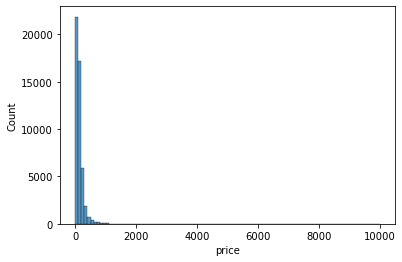

In [15]:
sns.histplot(df.price, bins=100)

<AxesSubplot:xlabel='price', ylabel='Count'>

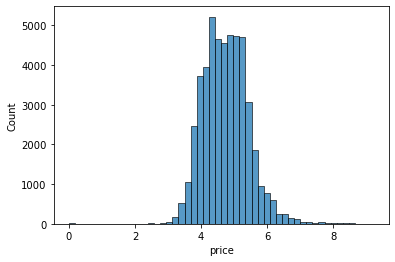

In [12]:
sns.histplot(np.log1p(df.price), bins=50)

# Data Wrangling

In [18]:
columns_of_interest = [ 'latitude'
                      , 'longitude'
                      , 'price'
                      , 'minimum_nights'
                      , 'number_of_reviews'
                      , 'reviews_per_month'
                      , 'calculated_host_listings_count'
                      ,'availability_365']
df = df[columns_of_interest]
df.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,40.64749,-73.97237,149,1,9,0.21,6,365
1,40.75362,-73.98377,225,1,45,0.38,2,355
2,40.80902,-73.94190,150,3,0,NaN,1,365
3,40.68514,-73.95976,89,1,270,4.64,1,194
4,40.79851,-73.94399,80,10,9,0.10,1,0


## Q1: Missing Values

In [17]:
df.isnull().sum()

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

## Q2: Median minimum_nights

In [23]:
df.minimum_nights.median()

3.0

## Split data

In [28]:
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

idx = np.arange(n)

np.random.seed(42)
np.random.shuffle(idx)

df_train      = df.iloc[idx[:n_train]]              .reset_index(drop=True)
df_test       = df.iloc[idx[n_train:n_train+n_test]].reset_index(drop=True)
df_val        = df.iloc[idx[n_train+n_test:]]       .reset_index(drop=True)
df_train_full = df.iloc[idx[:n_train+n_test]]       .reset_index(drop=True)

y_train      = np.log1p(df_train.price)
y_test       = np.log1p(df_test.price)
y_val        = np.log1p(df_val.price)
y_train_full = np.log1p(df_train_full.price)

del df_train     ['price']
del df_test      ['price']
del df_val       ['price']
del df_train_full['price']

## TRAINING FUNCTION

In [60]:
def prepare_X_zero(df):
    df = df.copy()
    df['reviews_per_month'] = df.reviews_per_month.fillna(0)
    X = df.values
    return X

def prepare_X_mean(df):
    df = df.copy()
    df['reviews_per_month'] = df.reviews_per_month.fillna(df.reviews_per_month.mean())
    X = df.values
    return X

def train_linear_regression_reg(X, y, r=0.001):
    X = np.column_stack([np.ones(X.shape[0]), X])
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

X_train_zero = prepare_X_zero(df_train)
X_val_zero   = prepare_X_zero(df_val)
X_train_mean = prepare_X_mean(df_train)
X_val_mean   = prepare_X_mean(df_val)

w0_zero, w_zero = train_linear_regression_reg(X_train_zero,y_train,r=0)
w0_mean, w_mean = train_linear_regression_reg(X_train_mean,y_train,r=0)

y_pred_zero = w0_zero + X_val_zero.dot(w_zero)
y_pred_mean = w0_mean + X_val_zero.dot(w_mean)

print('reviews_per_month na -> 0   : {}'.format(round(rmse(y_val,y_pred_zero),2)))
print('reviews_per_month na -> mean: {}'.format(round(rmse(y_val,y_pred_mean),2)))

reviews_per_month na -> 0   : 0.65
reviews_per_month na -> mean: 0.65


Neither is better to this accuracy, thechnically 0 is slightly better. But for the next question we use 0.

## Q4: What regularisation to use

In [85]:
prepare_X = prepare_X_zero
X_train = prepare_X(df_train)
X_val   = prepare_X(df_val)

res = []
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w0, w = train_linear_regression_reg(X_train,y_train,r=r)
    y_pred = w0 + X_val.dot(w)
    error = rmse(y_val,y_pred)
    print('{:10}:{} ({})'.format(r,error,round(error,2)))

         0:0.6536337649996121 (0.65)
     1e-06:0.6536338933922969 (0.65)
    0.0001:0.653651793240982 (0.65)
     0.001:0.6541885180213967 (0.65)
      0.01:0.6656175809489505 (0.67)
       0.1:0.6869575817254718 (0.69)
         1:0.6919185299146808 (0.69)
         5:0.6923850940178745 (0.69)
        10:0.6924224370107044 (0.69)


smallest error when r=0

In [70]:
r = 0

## Q5 What effect does seed have

In [81]:
def split_by_seed(seed):
    idx = np.arange(n)

    np.random.seed(seed)
    np.random.shuffle(idx)

    df_train      = df.iloc[idx[:n_train]]              .reset_index(drop=True)
    df_test       = df.iloc[idx[n_train:n_train+n_test]].reset_index(drop=True)
    df_val        = df.iloc[idx[n_train+n_test:]]       .reset_index(drop=True)
    df_train_full = df.iloc[idx[:n_train+n_test]]       .reset_index(drop=True)

    y_train      = np.log1p(df_train.price)
    y_test       = np.log1p(df_test.price)
    y_val        = np.log1p(df_val.price)
    y_train_full = np.log1p(df_train_full.price)

    del df_train     ['price']
    del df_test      ['price']
    del df_val       ['price']
    del df_train_full['price']
    return df_train, df_test, df_val, df_train_full, y_train, y_test, y_val, y_train_full

def calculate_rmse_by_seed(seed):
    df_train, df_test, df_val, df_train_full, y_train, y_test, y_val, y_train_full = split_by_seed(seed)
    
    X_train = prepare_X(df_train)
    X_val   = prepare_X(df_val)
    w0, w = train_linear_regression_reg(X_train,y_train,r=r)
    y_pred = w0 + X_val.dot(w)
    error = rmse(y_val,y_pred)
    return error

seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
errors = [ calculate_rmse_by_seed(seed) for seed in seeds]
print(errors)
print(np.std(errors))
print(np.round(np.std(errors),3))

[0.6304569982323267, 0.6486723821210312, 0.6409503261201178, 0.6396698468034724, 0.6555733448818004, 0.6391858794518651, 0.6473543640304936, 0.655889218349002, 0.6405135568815358, 0.6450366766956963]
0.007450888539027653
0.007


## Q6: Final model error

In [84]:
seed = 42
df_train, df_test, df_val, df_train_full, y_train, y_test, y_val, y_train_full = split_by_seed(seed)
X_train_full = prepare_X(df_train_full)
X_test       = prepare_X(df_test)

w0, w = train_linear_regression_reg(X_train_full,y_train_full,r=0.001)
y_test_pred = w0 + X_test.dot(w)
rmse(y_test,y_test_pred)

0.6433477825553248